# affine invariant ensemble sampler + parallel tempering

### 12D transporter model (single antiporter cycle)

10736.513516166175


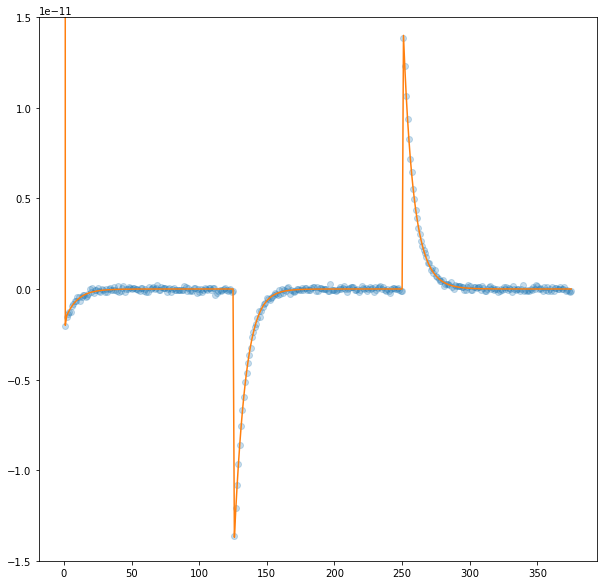

In [1]:
import numpy as np, tellurium as te, matplotlib.pyplot as plt
import emcee as mc, corner
np.random.seed(10)


# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


antimony_string = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = H_out_activation, S_out = S_out_activation;
            E2: at (time >= 10): H_out = 1e-7, S_out = 0.001;

            // Species initializations:
            H_out = 1e-07;
            H_out has substance_per_volume;

            H_in = 1e-7;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 1e-3;
            S_in has substance_per_volume;

            OF = 2.833e-8;
            OF has substance_per_volume;

            OF_Hb = 2.833e-8;
            OF_Hb has substance_per_volume;

            IF_Hb = 2.833e-8;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 2.833e-8;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 2.125e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 2.125e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Variable initializations:
            H_out_activation = 5e-8;
            S_out_activation = 0.001;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
            """ 


m = te.loada(antimony_string)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12

D = m.simulate(0, 15, 376, selections=['time', 'rxn4'])
y_true = D['rxn4']

noise_stdev_true = 1e-13
#y_obs = y_true + np.random.normal(0, noise_stdev_true, len(y_true))
y_obs = np.genfromtxt("data_grid_test3.csv", skip_header=1)

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o', alpha=0.25)
plt.plot(y_true)
plt.ylim(-1.5e-11, 1.5e-11)

log_like_ref = calc_norm_log_likelihood(y_true,noise_stdev_true,y_obs)

print(log_like_ref)

In [13]:
import time


def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    sigma = 10**theta[0]
    K=theta[1:]
    m = extra_parameters[0] 
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)

    try:
        D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
        y_tmp = D_tmp['rxn4']
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    except:
        log_like_tmp = -np.inf
    return log_like_tmp


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out_activation = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
 
    D_tmp = m.simulate(0,15, 376, selections=['time', 'rxn4'])
    y_tmp = D_tmp['rxn4']
    sigma = 1e-13
    log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def log_prior(theta):
    '''log of uniform prior distribution'''
    p0 = theta[0]
    p1 = theta[1]
    p2 = theta[2]
    p3 = theta[3]
    p4 = theta[4]
    p5 = theta[5]
    p6 = theta[6]
    p7 = theta[7]
    p8 = theta[8]
    p9 = theta[9]
    p10 = theta[10]
    p11 = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p0<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior


def set_p0():
    log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
    log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

    log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)

    ## near max likelihood
#     log_noise_sigma = np.random.uniform(np.log10(0.99e-13), np.log10(1.01e-13))
#     log_k1_f = np.random.uniform(9.99, 10.01) # log10 rate constant (ref=1e10)
#     log_k1_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3)
#     log_k2_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k2_r = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k3_f = np.random.uniform(6.99, 7.01)  # log10 rate constant (ref=1e7) 
#     log_k3_r = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_f = np.random.uniform(2.99, 3.01)  # log10 rate constant (ref=1e3) 
#     log_k4_r = np.random.uniform(9.99, 10.01)  # log10 rate constant (ref=1e10)
#     log_k5_f = np.random.uniform(1.99, 2.01)  # log10 rate constant (ref=1e2)
#     log_k5_r = np.random.uniform(1.99, 2.01)   # log10 rate constant (ref=1e2)
#     log_k6_f = np.random.uniform(2.99, 3.01)  # log10  rate constant (ref=1e3)
    
    p0_list_tmp = [
                log_noise_sigma ,
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
    ]
    return p0_list_tmp

seed = 12
np.random.seed(seed)

betas = np.array([1e-12, 1e-9, 1e-5, 1e-3, 0.01, 0.05, 0.15, 0.35, 0.55, 0.75, 0.85, 0.95, 0.99, 1])
n_temps = len(betas)
extra_parameters = [m]
n_steps = 10000
n_walkers = 120
n_dim = 12

p0_t_list = []
for t in range(n_temps):
    p0_t_i = []
    for i in range(n_walkers):
        p0_t_i.append(set_p0())
    p0_t_list.append(p0_t_i)
p0 = np.asarray(p0_t_list)

assert(np.shape(p0) == (n_temps,n_walkers,n_dim))

p_ref = [-13,10,3,2,2,7,3,3,10,2,2,3]
print(f"ref log likelihood: {log_likelihood(p_ref,y_obs,extra_parameters)}")
sampler = mc.PTSampler(n_temps, n_walkers, n_dim, log_likelihood, log_prior, loglargs=[y_obs, extra_parameters], betas=betas )

t_0 = time.time()
pos, lnprob, rstate = sampler.run_mcmc(p0, n_steps)
t_run = time.time() - t_0
print(f"wall clock: {t_run} s")

lp = sampler.lnprobability
print(f"{np.size(lp)} likelihood calculations")
print(f"{np.size(lp)/t_run} likelihood calculations / sec " )

ref log likelihood: 10736.513516166175


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.90902e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.40668e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.10037e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.45994e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.42529e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.42892e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.80839e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.02724e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.24876e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.56136e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.6173e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.741e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, M

wall clock: 11048.819033145905 s
16800000 likelihood calculations
1520.5244967449319 likelihood calculations / sec 


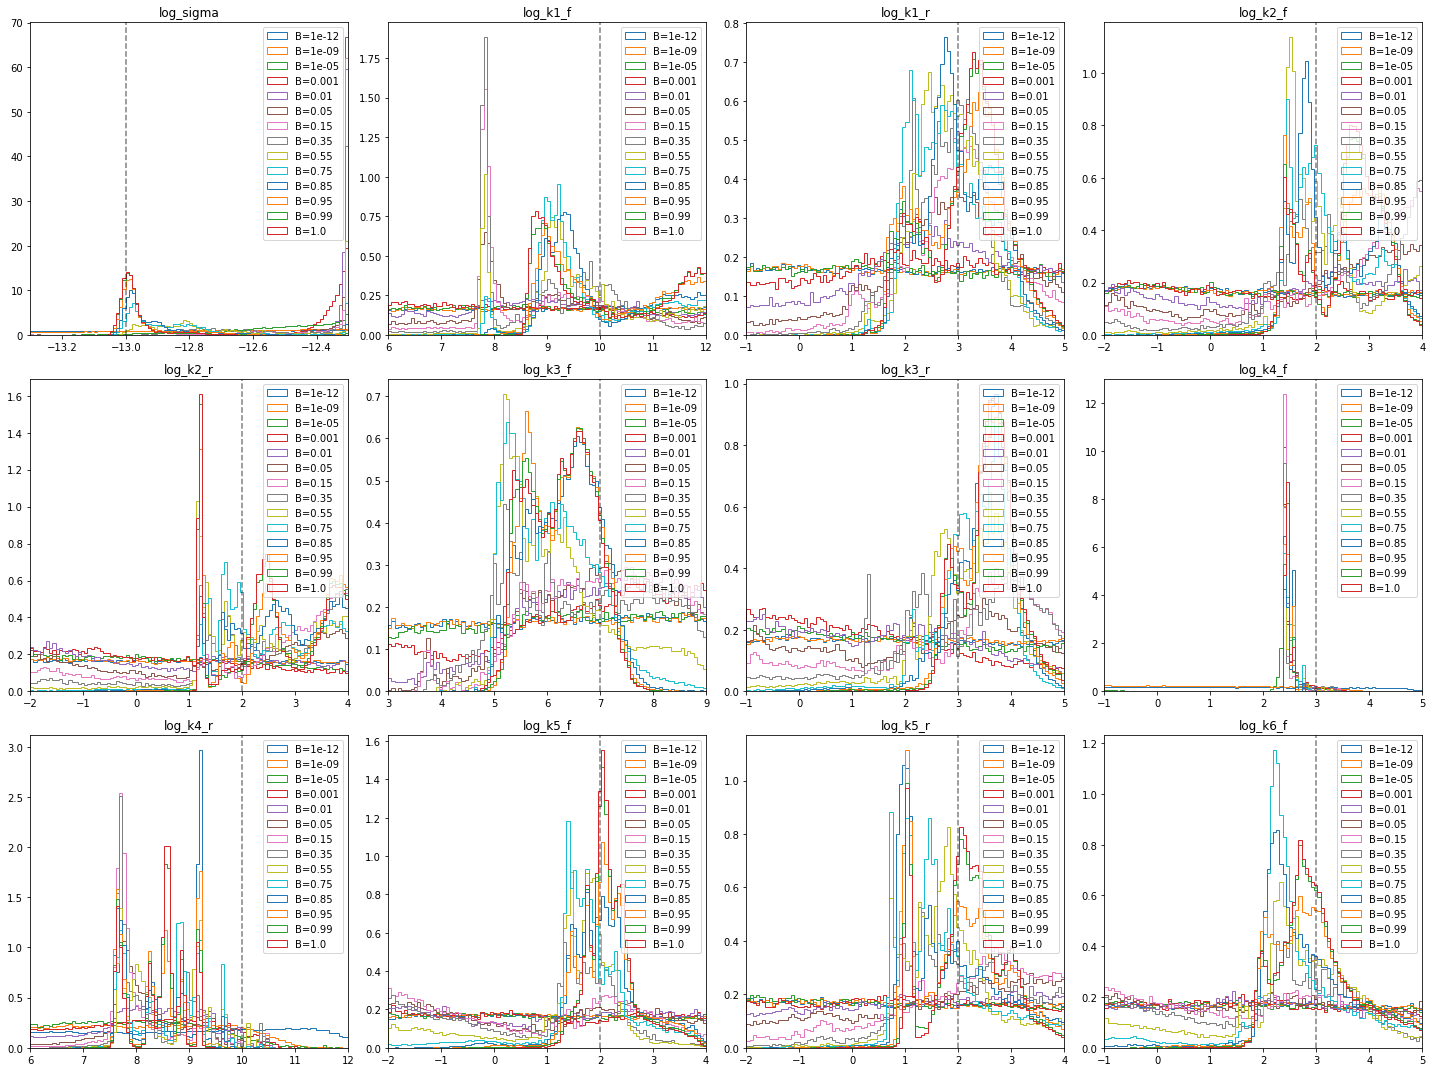

In [14]:
import corner

p_info = [
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
]

samples = [np.transpose(sampler.flatchain[i,:,:]) for i in range(n_temps)]
#colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple','black' ]
#colors = ['red', 'green',  'blue', 'black' ]
#assert(len(samples)==len(colors))

### 1D posterior plot
fig, ax = plt.subplots(3,4, figsize=(20,15))
axes = ax.flatten()

for i, ax_i in enumerate(axes):
    p_tmp = p_info[i]
    ax_i.set_title(f"{p_tmp[0]}")
    ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
    ax_i.set_xlim(p_tmp[1],p_tmp[2])
    
    
    for j, samples_t in enumerate(samples):
        #ax_i.hist(samples_t[i], 100, histtype="step", color=colors[j], density=True, range=(p_tmp[1],p_tmp[2]), label=f'B={betas[j]}')
        ax_i.hist(samples_t[i], 100, histtype="step", density=True, range=(p_tmp[1],p_tmp[2]), label=f'B={betas[j]}')
        ax_i.legend()
plt.tight_layout()
#plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}.png')

In [ ]:
import pandas as pd
df = pd.DataFrame(np.transpose(samples[-1])[::1000], columns=[p[0] for p in p_info])
print(df)
df.to_csv(f'12D_transporter_AIES_PT_B1_samples_s{seed}.csv', sep=',')



# 12D model (recent)

model configuration...
[10, 3, 2, 2, 7, 3, 3, 10, 2, 2, 3, -13]
log_prob_ref: 7134.32084509393
t0 timestamp: 1653114465.28593
sampling configuration...
random seed: 10
n dim: 12
N steps: 10000
K walkers: 100
M temps: 100
N*K*M total samples: 100000000
#####################
initializing...
sampling...


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.29954e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.10695e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.85184e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.35908e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.23858e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.53685e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.65608e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.73423e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.29304e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.60208e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.6413e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.0672e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.36522e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.83994e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.09602e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.93111e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.77942e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.41944e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.9501e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.71711e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.6557e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.41078e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.37018e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.46679e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.39812e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.1259e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.46008e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.09162e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.64931e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.09667e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.73374e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.61857e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.64702e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.71587e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.68785e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.02373e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.03673e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.19408e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.02169e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.59126e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.34207e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.36939e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.28957e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.54651e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.56759e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.08741e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.11202e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.74117e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.38434e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.51933e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.45856e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.52726e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.741e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.82243e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.95541e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.2083e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.31497e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.24163e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.61581e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.46378e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.26682e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.14124e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.66591e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.29833e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.59118e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.75139e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.98783e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.45604e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.55694e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.38387e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.43786e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.46616e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.90746e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.91533e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.46699e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.18238e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.95608e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.6809e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.40837e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.36618e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.45614e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.01138e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.42218e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.65953e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 7.71192e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.45765e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.39289e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.76734e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.97633e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.43931e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.22548e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.02688e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.36031e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.51665e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.4744e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.25311e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.62015e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.17826e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.27147e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.94246e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.53135e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.34863e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.30326e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.57289e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.52947e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.84139e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.72516e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.0407e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.23198e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.48621e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.07219e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.28516e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.49223e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.51468e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.48513e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.44478e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.3263e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.54892e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 7.35234e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.33428e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.02263e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.52971e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.01108e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.53442e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.01599e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.54363e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.91571e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.01838e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.72085e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.33354e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 7.98188e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.33463e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.6133e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.88003e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.76024e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.09485e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.69862e-29, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.35219e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.76635e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.07932e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.10736e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.96933e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.79122e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.3107e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.7221e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.58329e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.40733e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.06619e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.50192e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.7103e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.66524e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.34371e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.16131e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.2919e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.79896e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.15086e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.39286e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.19798e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.18978e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.19637e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.0119e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.18156e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.22589e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 7.45502e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.16678e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.05617e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.35604e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.94851e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.86939e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.87984e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.55661e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.01356e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.75832e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.62708e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.33953e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.19069e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.04751e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.823e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.7654e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.61829e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, M

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.77209e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.74549e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.58065e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.41604e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.89616e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.17904e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.78494e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.00998e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.42281e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.662e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 3.07519e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.85194e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.43371e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.6625e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.65495e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.26014e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.23386e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 5.5444e-28, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, 

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.04404e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.03136e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.34191e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.71624e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.0934e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.91516e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE,

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.68663e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 9.79044e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.88722e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.04197e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 4.42692e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.43559e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.55421e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 8.83626e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 6.34071e-27, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.65567e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.51134e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.26541e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.30366e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.39247e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.86519e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 1.34235e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.66371e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0 and h = 2.42595e-26, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE

tf timestamp: 1653150248.2885928
wall clock: 35783.00266289711 s
2794.6229370988085 samples/sec
max sampled likelihood: 7136.318815592615


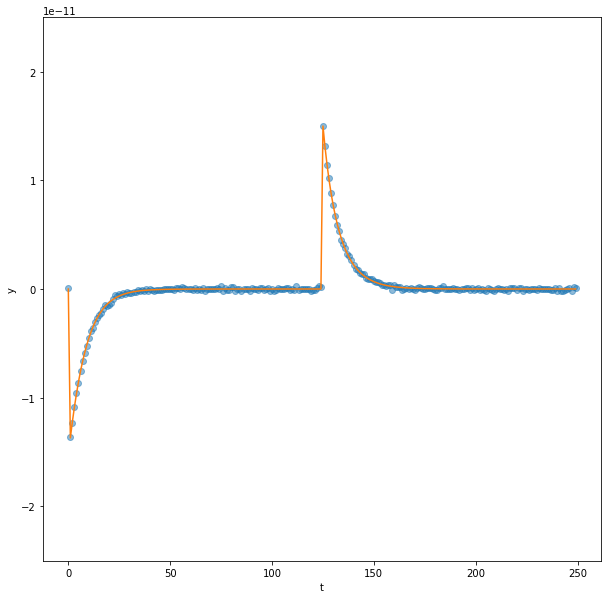

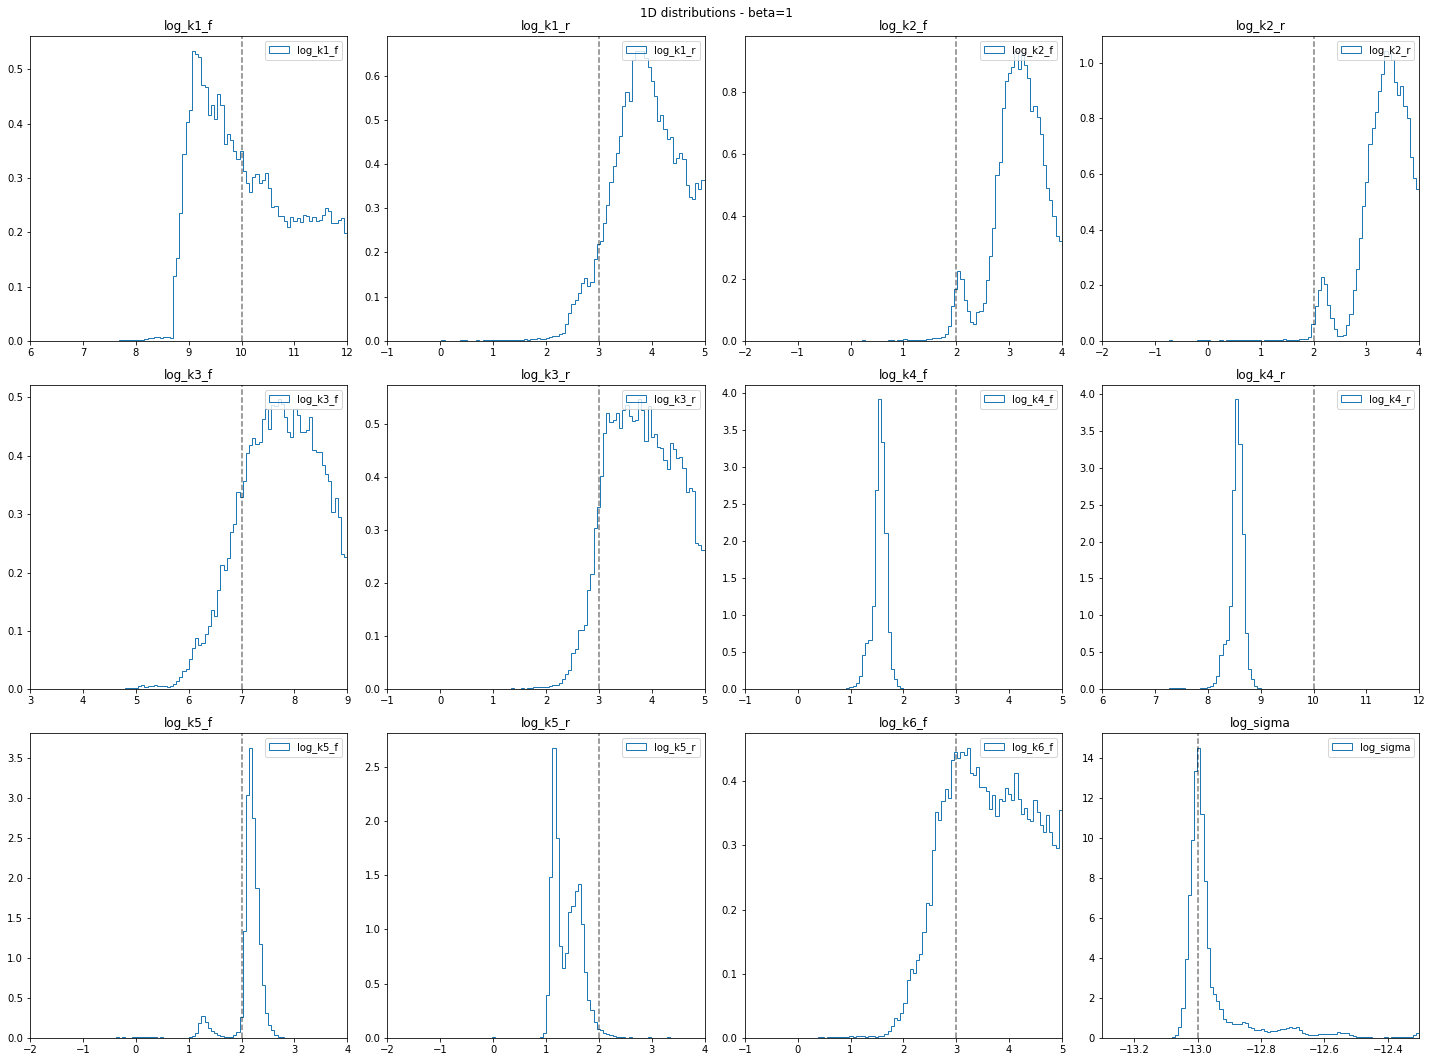

In [16]:
import numpy as np
import scipy.stats as stats, scipy as sp
import seaborn as sns
import emcee as mc
import matplotlib.pyplot as plt
import tellurium as te
import time
import corner as corner
import multiprocessing as mp


### 12d transporter

# Normal log-likelihood calculation
def calc_norm_log_likelihood(mu,sigma,X):
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = len(X)
    f1 = -1*(n/2)*np.log(2*np.pi*sigma**2)
    f2_a = -1/(2*sigma**2)
    f2_b = 0 
    for i in range(n):
        f2_b += (X[i]-mu[i])**2
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
    return log_likelihood


def calc_grid_point(K,y_obs,m):
    m.resetToOrigin()
    m.H_out = 5e-8
    m.integrator.absolute_tolerance = 1e-18
    m.integrator.relative_tolerance = 1e-12
    m.k1_f = 10**K[0]
    m.k1_r = 10**K[1]
    m.k2_f = 10**K[2]
    m.k2_r = 10**K[3]
    m.k3_f = 10**K[4]
    m.k3_r = 10**K[5]
    m.k4_f = 10**K[6]
    m.k4_r = 10**K[7]
    m.k5_f = 10**K[8]
    m.k5_r = 10**K[9]
    m.k6_f = 10**K[10]
    m.k6_r = (m.k1_f*m.k2_f*m.k3_f*m.k4_f*m.k5_f*m.k6_f)/(m.k1_r*m.k2_r*m.k3_r*m.k4_r*m.k5_r)
    try:
        D_tmp = m.simulate(0, 10, 250, selections=['time', 'rxn4'])
        y_tmp = D_tmp['rxn4']
        sigma = 10**K[11]
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    except:
        y_tmp = np.zeros(250)
        sigma = 10**K[11]
        log_like_tmp = calc_norm_log_likelihood(y_tmp,sigma,y_obs)
    return log_like_tmp


def log_prior(theta):
    '''log of uniform prior distribution'''
    
    p1 = theta[0]
    p2 = theta[1]
    p3 = theta[2]
    p4 = theta[3]
    p5 = theta[4]
    p6 = theta[5]
    p7 = theta[6]
    p8 = theta[7]
    p9 = theta[8]
    p10 = theta[9]
    p11 = theta[10]
    p_sigma = theta[11]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if (np.log10(5e-14)<p_sigma<np.log10(5e-13)) and (6<p1<12) and (-1<p2<5) and (-2<p3<4) and (-2<p4<4) and \
        (3<p5<9) and (-1<p6<5) and (-1<p7<5) and (6<p8<12) and (-2<p9<4) and (-2<p10<4) and (-1<p11<5):
        return 0  
    else:
        return -np.inf
    

def log_prob(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    m = extra_parameters[0]
    beta = extra_parameters[1]
    log_pr = log_prior(theta)
    log_l = calc_grid_point(theta, y_obs, m)
    if not np.isfinite(log_pr):
        return -np.inf  # ~zero probability
    if not np.isfinite(log_l):
        return -np.inf  # ~zero probability
    else:
        log_prob = log_pr + beta*log_l  # log posterior ~ log likelihood + log prior
        return log_prob


def set_p0():
    '''set initial walker positions'''
    
    log_k1_f = np.random.uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k2_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)

    log_k3_f = np.random.uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_f = np.random.uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r = np.random.uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f = np.random.uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r = np.random.uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f = np.random.uniform(-1,5)  # log10  rate constant (ref=1e3)
    log_noise_sigma = np.random.uniform(np.log10(5e-14), np.log10(5e-13))
    
    p0_list_tmp = [        
                log_k1_f ,
                log_k1_r ,
                log_k2_f ,
                log_k2_r ,
                log_k3_f , 
                log_k3_r ,
                log_k4_f ,
                log_k4_r ,
                log_k5_f ,
                log_k5_r ,
                log_k6_f ,
                log_noise_sigma ,
    ]
    return p0_list_tmp


def plot_samples(samples, p_info, beta):
    
    ### 1D posterior plot
    samples_T = np.transpose(samples)
    fig, ax = plt.subplots(3,4, figsize=(20,15))
    axes = ax.flatten()

    for i, ax_i in enumerate(axes):
        p_tmp = p_info[i]
        ax_i.set_title(f"{p_tmp[0]}")
        ax_i.axvline(p_tmp[3],ls='--', color='black', alpha=0.5)
        ax_i.set_xlim(p_tmp[1],p_tmp[2])


        ax_i.hist(samples_T[i], 100, histtype="step", density=True, range=(p_tmp[1],p_tmp[2]), label=f'{p_tmp[0]}')
        ax_i.legend()

    plt.suptitle(f'1D distributions - beta={beta}')
    plt.tight_layout()
    
    #plt.savefig(f'12D_transporter_AIES_PT_1D_dist_s{seed}_random.png') 
    

def calculate_weights(log_like, beta_old, beta_new):
    log_w = (beta_new-beta)*log_like
    log_w_rel = log_w-np.max(log_w)
    w_rel = np.exp(log_w_rel)
    return w_rel
    

def calculate_next_beta(log_like, beta_old, threshold):
    def f(x):
        avg_w_rel =  np.mean(calculate_weights(log_like, beta_old, x))    
        return avg_w_rel-threshold
    
    beta_new = sp.optimize.root(f, beta_old).x[0]
    assert(beta_old <= beta_new)
    if beta_new >= 1.0:
        beta_new = 1.0
    else:
        assert(np.isclose(np.mean(calculate_weights(log_like, beta_old, beta_new)),threshold))
    return beta_new


def calculate_p_rel(log_like, beta_old, beta_new):
    w_rel = calculate_weights(log_like, beta, beta_new)
    mean_w_rel = np.mean(w_rel)
    p_rel = w_rel/np.sum(w_rel)
    assert(np.isclose(np.sum(p_rel),1.0))
    return p_rel
    
    
### model configuration
print('model configuration...')
antimony_string_SS = f"""
            // Created by libAntimony v2.12.0
            model transporter_full()

            // Compartments and Species:
            compartment vol;
            species OF in vol, OF_Hb in vol;
            species IF_Hb in vol, IF_Hb_Sb in vol;
            species IF_Sb in vol, OF_Sb in vol;
            species H_in in vol, S_in in vol;
            species $H_out in vol, $S_out in vol;

            // Reactions:
            rxn1: OF + $H_out -> OF_Hb; vol*(k1_f*OF*H_out - k1_r*OF_Hb);
            rxn2: OF_Hb -> IF_Hb; vol*(k2_f*OF_Hb - k2_r*IF_Hb);
            rxn3: IF_Hb + S_in -> IF_Hb_Sb; vol*(k3_f*IF_Hb*S_in - k3_r*IF_Hb_Sb);
            rxn4: IF_Hb_Sb -> IF_Sb + H_in; vol*(k4_f*IF_Hb_Sb - k4_r*IF_Sb*H_in);
            rxn5: IF_Sb -> OF_Sb; vol*(k5_f*IF_Sb - k5_r*OF_Sb);
            rxn6: OF_Sb -> OF + $S_out; vol*(k6_f*OF_Sb - k6_r*OF*S_out);
            

            // Events:
            E1: at (time >= 5): H_out = 1e-7, S_out = 1e-3;
            

            // Species initializations:
            H_out = 5e-8;
            H_out has substance_per_volume;

            H_in = 9.999811082242941e-08;
            H_in has substance_per_volume;

            S_out = 0.001;
            S_out has substance_per_volume;

            S_in = 0.0009999811143288836;
            S_in has substance_per_volume;

            OF = 4.7218452046117796e-09;
            OF has substance_per_volume;

            OF_Hb = 4.7218452046117796e-09;
            OF_Hb has substance_per_volume;

            IF_Hb = 4.7218452046117796e-09;
            IF_Hb has substance_per_volume;
            
            IF_Hb_Sb = 4.721756029392908e-08;
            IF_Hb_Sb has substance_per_volume;
            
            IF_Sb = 4.721845204611779e-08;
            IF_Sb has substance_per_volume;

            OF_Sb = 4.721845204611775e-08;
            OF_Sb has substance_per_volume;


            // Compartment initializations:
            vol = 0.0001;
            vol has volume;

            // Rate constant initializations:
            k1_f = 1e10;
            k1_r = 1e3;
            k2_f = 1e2;
            k2_r = 1e2;
            k3_f = 1e7;
            k3_r = 1e3;
            k4_f = 1e3;
            k4_r = 1e10;
            k5_f = 1e2;
            k5_r = 1e2;
            k6_f = 1e3;
            k6_r = 1e7;


            // Other declarations:
            const vol;
            const k1_f, k1_r, k2_f, k2_r, k3_f, k3_r;
            const k4_f, k4_r, k5_f, k5_r, k6_f, k6_r;
    

            // Unit definitions:
            unit substance_per_volume = mole / litre;
            unit volume = litre;
            unit length = metre;
            unit area = metre^2;
            unit time_unit = second;
            unit substance = mole;
            unit extent = mole;

            // Display Names:
            time_unit is "time";
            end
""" 
seed = 10
np.random.seed(seed)

m = te.loada(antimony_string_SS)
m.integrator.absolute_tolerance = 1e-18
m.integrator.relative_tolerance = 1e-12
m.H_out = 5e-8
D1 = m.simulate(0, 10, 250, selections=['time', 'rxn4'])
y_true = D1['rxn4']

noise_stdev_true = 1e-13
y_obs = np.genfromtxt("data_grid_test3_1exp.csv")

plt.figure(figsize=(10,10))
plt.plot(y_obs, 'o', alpha=0.5)
plt.plot(y_true)
plt.ylim(-2.5e-11, 2.5e-11)
plt.ylabel('y')
plt.xlabel('t')

p_info = [   
    ["log_k1_f",6,12,10],
    ["log_k1_r",-1,5,3],
    ["log_k2_f",-2,4,2],
    ["log_k2_r",-2,4,2],
    ["log_k3_f",3,9,7],
    ["log_k3_r",-1,5,3],
    ["log_k4_f",-1,5,3],
    ["log_k4_r",6,12,10],
    ["log_k5_f",-2,4,2],
    ["log_k5_r",-2,4,2],
    ["log_k6_f",-1,5,3],
    ["log_sigma",np.log10(5e-14), np.log10(5e-13), -13],
]
param_ref = [p_i[3] for p_i in p_info]
print(param_ref)

# beta_test = [1e-6, 1e-4, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

# for b in beta_test:

#     make_2d_prob_grid(n_grid=100, a_range=[6,12], b_range=[-1,5], beta=b, K_true=[10,3], y_obs=y_obs, m=m )

print(f'log_prob_ref: {log_prob(param_ref, y_obs, [m,1])}')


#### sampling settings
t0 = time.time()
print(f't0 timestamp: {t0}')
print('sampling configuration...')
seed = 10
np.random.seed(seed)
dim = 12

N_steps = 100
K_walkers = 100
burn_in = 1000
M_temps = 100
NKM_samples = N_steps*K_walkers*M_temps

print(f'random seed: {seed}')
print(f'n dim: {dim}')
print(f'N steps: {N_steps}')
print(f'K walkers: {K_walkers}')
print(f'M temps: {M_temps}')
#print(f'burn in: {burn_in}')
print(f'N*K*M total samples: {NKM_samples}')
print(f'#####################')


### step 1: initialization
print('initializing...')


p0_t_list = []
for t in range(M_temps):
    p0_t_i = []
    for i in range(K_walkers):
        p0_t_i.append(set_p0())
    p0_t_list.append(p0_t_i)
p0 = np.asarray(p0_t_list)

assert(np.shape(p0) == (M_temps,K_walkers,dim))
print('sampling...')
t_0 = time.time()
# with mp.Pool(processes=2) as pool:
#     sampler = mc.PTSampler(M_temps, K_walkers, dim, calc_grid_point, log_prior, loglargs=[y_obs, m], pool=pool)
#     pos, lnprob, rstate = sampler.run_mcmc(p0, N_steps)
# samples = sampler.flatchain[0,:,:]


sampler = mc.PTSampler(M_temps, K_walkers, dim, calc_grid_point, log_prior, loglargs=[y_obs, m])
pos, lnprob, rstate = sampler.run_mcmc(p0, N_steps)
samples = sampler.flatchain[0,:,:]

lp = sampler.lnprobability

tf = time.time()
print(f'tf timestamp: {tf}')
print(f'wall clock: {tf-t0} s')
print(f'{(NKM_samples)/(tf-t0)} samples/sec' )

print(f'max sampled likelihood: {np.max(lp[0,:,:])}')
plot_samples(samples,p_info, 1)